# **Objective**

A online recipe website that you work in wants to automatically suggest tags to users who regularly share recipes (in text form) in their website. Your company's data team has already prepared a dataset with annotations (see attached) and your AI team is exploring the use of more modern neural network architectures for Named Entity Recognition.

In particular, ELmo Embedding is what your AI team lead feel might be a good balance between accuracy and affordable GPU resource usage compared to the traditional models such as Word2Vec or GLoVE embeddings. 

Your lead has assigned you to look into it and has passed you a Notebook template. You'll have to adapt the Colab Notebook to process the dataset, create a Keras model with ELmo Embedding, train the model, evaluate the performance, perform your own testing of the model, and save the model.


---


## A2.0 Preparation

In this section we will train our Entity Recognition Model using Elmo Embedding.

Before starting, upload the two files:
- restauranttest.bio.txt
- restauranttrain.bio.txt

to your Google Drive in the **/Data/A2** folder




## A2.1 Mount Google Drive

Run the following cell, as is, to mount Google Drive.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## A2.2 List the Files in the Data/A2 Folder

Run the following cell to list the files in your folder. Be sure to have uploaded your .npy files from Part 1 of the Assignment to this folder.

In [0]:
!ls /content/drive/My\ Drive/Data/A2

 restauranttest.bio.txt   'train_2020-02-14 17-00-24'
 restauranttrain.bio.txt  'train_2020-02-14 17-00-55'


## A2.3 Import Libraries

Run the following cell, as is, to import the necessary libraries.

In [0]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras
import tensorflow_hub as hub

from datetime import datetime
from tensorflow.keras import backend as K
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Layer, Dense, Activation, Input, Bidirectional, Dropout, LSTM, TimeDistributed, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.utils import to_categorical

folder = "/content/drive/My Drive/Data/A2/"


## A2.4 Set Maximum Sentence Length 

Set the maximum sentence length to a suitable value. You can try setting this to a smaller value later, once you've loaded and processed the files and determined what the maximum number of words per sentence is.

The following is an example of how you would set the max sentence length variables:

```
    max_seq_length = 500
```

In [0]:
import pandas as pd
# TODO:
# Set the maximum number of words per sentence.
#
#.............CODES START HERE.............#

max_seq_length = 500

#.............CODES END HERE.............#



## A2.5 Set the Entity-to-Index Mapping 

Set the entity-to-index mapping.

This should be a dictionary of unique entity values to an index in a one-hot vector that you want to set.

To take reference from the Practical 9, the entity-to-index for that set of data was declared as such:

```
    entity_to_index = {'O': 0, 
                        'B-ORG': 1, 
                        'I-ORG': 2, 
                        'B-MISC': 3, 
                        'I-MISC': 4, 
                        'B-PER': 5, 
                        'I-PER': 6, 
                        'B-LOC': 7, 
                        'I-LOC': 8 }
```

What is an easy to determine the list of unique values from the data set? There are many tools available at your disposable, include codes in this assignment. 

In [0]:
# TODO:
# Construct a list of I- O- B- annotations and the indexes that will help 
# form our intent classification one-hot vector later on.
#

#.............CODES START HERE.............#
entity_to_index = {'O': 0, 
                     'B-Rating': 1, 
                     'I-Rating': 2, 
                     'B-Amenity': 3, 
                     'I-Amenity': 4, 
                     'B-Location': 5, 
                     'I-Location': 6, 
                     'B-Price': 7, 
                     'I-Price': 8,
                     'B-Hours': 9, 
                     'I-Hours': 10, 
                     'B-Restaurant_Name': 11, 
                     'I-Restaurant_Name': 12, 
                     'B-Dish': 13, 
                     'I-Dish': 14, 
                     'B-Cuisine': 15, 
                     'I-Cuisine': 16  }
#.............CODES END HERE.............#

## A2.6 Declare the Method to Process File

Run the following code, as is, to declare the method to process the file.

*NOTE: This code is not entirely the same as the one provided in Practical 9.*

In [0]:
# Process a file and return the following two arrays:
#
#   x - (num_sentences, max_words)
#       A Numpy array of strings.
#
#   y - (num_sentences, classes)
#       A Numpy array of floats (one-hot encoding of the classes)
#
def process_file(filepath, max_words_per_sentence):
    f = open(os.path.join(filepath), encoding='utf8')
    
    sentences_words = []
    sentences_entities = []
    sentence_words = []
    sentence_entities = []
    
    for line in f:
        line = line.strip()
        
        # Once we reach an empty, this indicates the end
        # of a sentence, and we will append the current
        # word and entity list to the bigger list.
        #
        if line == "":
            if len(sentence_words) > 0:
                sentences_words.append(sentence_words)
                sentences_entities.append(sentence_entities)
                
            # Clear the current word and entity list
            sentence_words = []
            sentence_entities = []
            
            # End this line and proceed to the next line immediately
            #
            continue
            
        # Get the line of text 
        word_list = line.split()
        
        # The second element contains the word
        word = word_list[1].lower()
        
        # The first element contains the entity
        entity = word_list[0]

        if word != "n't":
            
            # Add the word to a list
            sentence_words.append(word)

            # Add the entity to a list
            sentence_entities.append(entity)
            
        else:
            
            if len(sentence_words) > 0:
                
                # Add the "n't" to the previous word
                sentence_words[len(sentence_words) - 1] += word

    
    # Once the loop ends, add the current word list and entity
    # list to the bigger list.
    #
    if len(sentence_words) > 0:
        sentences_words.append(sentence_words)
        sentences_entities.append(sentence_entities)
    
    f.close()    
    
    # Perform padding
    #
    max_sentence_len_in_this_dataset = len(max(sentences_words, key=lambda x: len(x)))
    print ("The max sentence length in this dataset = %d" % max_sentence_len_in_this_dataset)
    
    sentences_words = pad_sequences(sentences_words, maxlen=max_words_per_sentence, dtype=object, padding='post', value="--PAD--")
    sentences_entities = pad_sequences(sentences_entities, maxlen=max_words_per_sentence, dtype=object, padding='post', value="O")
        
    # run one-hot encoding
    #
    entity_size = len(entity_to_index)
    sentences_entities = [[to_categorical(entity_to_index[word], entity_size) for word in sentence] for sentence in sentences_entities]
    
    return sentences_words, sentences_entities        



## A2.7 Load and Process Your Data 

Modify the following cell below to call the **process_file** method to load and process your data and save it into the following 4 variables:

- x_train
- y_train
- x_test
- y_test

If you do this correctly, the shape from your variables should look like the following:
```
    x_train.shape: (7660, ###)
    y_train.shape: (7660, ###, 17)
    x_test.shape:  (1521, ###)
    y_test.shape:  (1521, ###, 17)
```

*NOTE: The ### is your max sentence length*

In [0]:
# TODO:
# Call the process_file method to load and retrieve the data from the 
# restauranttrain.bio.txt and restauranttest.bio.txt dataset.
#
# After that, save it into 4 numpy arrays:
#   x_train, y_train
#   x_test, y_test
#
#.............CODES START HERE.............#
data_folder = '/content/drive/My Drive/Data/A2/'
sentences_words, sentences_entities = process_file(data_folder + 'restauranttrain.bio.txt',36)

x_train = np.array(sentences_words)
y_train = np.array(sentences_entities)

sentences_words, sentences_entities = process_file(data_folder + 'restauranttest.bio.txt',36)

x_test = np.array(sentences_words)
y_test = np.array(sentences_entities)


#.............CODES END HERE.............#

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


The max sentence length in this dataset = 35
The max sentence length in this dataset = 26
(7660, 36)
(7660, 36, 17)
(1521, 36)
(1521, 36, 17)


## A2.8 Create Our ELMo Embedding Layer

The pre-trained ELMo Embedding Layer is currently hosted on Tensorflow Hub and will be downloaded through the Tensorflow Hub as a Tensorflow graph.

We then wrap it around an ElmoEmbeddingLayer class that we can these use in our Keras layers. See the following for reference on how to wrap ELMo in a Keras layer:
- https://towardsdatascience.com/elmo-embeddings-in-keras-with-tensorflow-hub-7eb6f0145440

*NOTE: Do **NOT** modify the codes in the cell below*



In [0]:
# Initialize the Tensorflow session.
#
# This is required because we are using pre-built/trained models downloaded 
# from Tensorflow Hub, which creates a Tensorflow graph to represent
# the model.
#
# See https://www.tensorflow.org/hub to find out more about
# Tensorflow Hub.
#
sess = tf.Session()
K.set_session(sess)

# This is our custom Keras layer to wrap the ELMo embedding layer
# downloaded from Tensorflow hub. Once this Keras layer is declared
# it can be inserted into our own Keras model later on.
#
class ElmoEmbeddingLayer(Layer):
    def __init__(self, **kwargs):
        self.dimensions = 1024
        self.trainable = True
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.elmo = hub.Module('https://tfhub.dev/google/elmo/3', trainable=self.trainable,
                               name="{}_module".format(self.name))
        
        # The ELmo Embedding has LSTM and CNN layers where the weights
        # should be frozen, but it has 4 others weights (as described
        # in ELmo's paper), which we will inform Keras that these weights 
        # are trainable.
        #
        self._trainable_weights += tf.trainable_variables(scope="^" + self.name + "_module/.*")
        super(ElmoEmbeddingLayer, self).build(input_shape)

    def call(self, x):
        sequence_lengths = tf.cast(tf.count_nonzero(x, axis=1), dtype=tf.int32)
       
        inputs = {
            "tokens": x,
            "sequence_len": sequence_lengths
        }
        return self.elmo(inputs, signature="tokens", as_dict=True)["elmo"]

    def compute_mask(self, inputs, mask=None):
        return K.not_equal(inputs, '--PAD--')

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.dimensions)




## A2.9 Design and Create Your Own Model 

Write the code to design and create your own model. We are going to use the Elmo Embedding Layer in between your Input layer and any layers that you like to appear after.

You **must** have at least 1 LSTM layer.

*HINT: The following link https://towardsdatascience.com/elmo-embeddings-in-keras-with-tensorflow-hub-7eb6f0145440 shows an example of how to use ElmoEmbeddingLayer in your model. If you have a look at the ElmoEmbeddingLayer code above, it already generates a mask for the next LSTM layer, so you do NOT need a separate Masking layer*



In [0]:
from keras.layers.merge import add
def create_model():
    # TODO:
    #.............CODES START HERE.............#
    input_text = layers.Input(shape=(36,), dtype=tf.string)
    embedding = ElmoEmbeddingLayer()(input_text)
    x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
    
    #x_rnn = Bidirectional(LSTM(units=512, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))(x)
    #x = add([x, x_rnn])  # residual connection to the first biLSTM
    out = TimeDistributed(Dense(len(entity_to_index), activation="softmax"))(x)

    model = Model(input_text, out)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    #.............CODES END HERE.............#

    # You must keep the following line to initialize all 
    # Tensorflow variables.
    #
    sess.run(tf.global_variables_initializer())
    return model
  

Using TensorFlow backend.


## A2.10 Create and Train Model 

Create and then train your LSTM model. 

Ensure that you compute and pass in your class weights to Keras for the training. You can consider running this for **3 epochs or more**. 

You do NOT need to implement checkpoints.

**Retain the results in the your Colab Notebook for submission**.

*HINT: A reasonable validation accuracy should be >= 85%*


In [0]:
# TODO:
# Create your model and train it with your data.

#.............CODES START HERE.............#
model = create_model()
model.summary()


# Create the training folder
#
training_session_id = datetime.now().strftime("%Y-%m-%d %H-%M-%S")
training_session_folder = folder + '/train_%s' % (training_session_id)
os.makedirs(training_session_folder, exist_ok=True)


# Configure the checkpoint and stop point.
# This allows the training to save the best models and also stop the
# training early if it detects that there are no improvements after
# a long time.
#
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath=training_session_folder + '/model.{epoch:04d}-acc-{acc:4.2f}-val_acc-{val_acc:4.2f}-loss-{val_loss:4.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
]


# TODO:
# Train our model
#
history = model.fit(x=x_train, y=y_train, batch_size=20, epochs=5, 
                        callbacks=callbacks_list, validation_data=(x_test, y_test))

#.............CODES END HERE.............#



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 36)]              0         
_________________________________________________________________
elmo_embedding_layer_2 (Elmo (None, None, 1024)        4         
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 1024)        6295552   
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 17)          17425     
Total params: 6,312,981
Trainable params: 6,312,981
Non-trainable params: 0
_________________________________________________________________
Train on 7660 samples, validate on 1521 samples
Epoch 1/5
7660/7660 [==============================] - 130s 17ms/sample - loss: 0.1094 - acc: 0.8708 - val_loss: 0.0820 - val_acc: 0.9000
Epoch 2/5
7660/7660 [==============================] - 122s 1

In [0]:
import glob

# List all the .h5 files generated in your training folder.
#
list_of_files = glob.glob(training_session_folder + '/*')  
list_of_files.sort()
best_model_file = list_of_files[-1]

print ("Best model file:")
print (best_model_file)

# And save it into another file.
#
model.save(training_session_folder + "/best_model_file.h5")

Best model file:
/content/drive/My Drive/Data/A2//train_2020-02-23 10-42-11/model.0002-acc-0.92-val_acc-0.91-loss-0.08.h5


## A2.11 Evaluate Your Training and Model Performance 

Modify the following code below to evaluate your performance by calling the **display_training_loss_and_accuracy** and the **display_classification_confusion_matrix** methods.

**Retain the results in the your Colab Notebook for submission**.


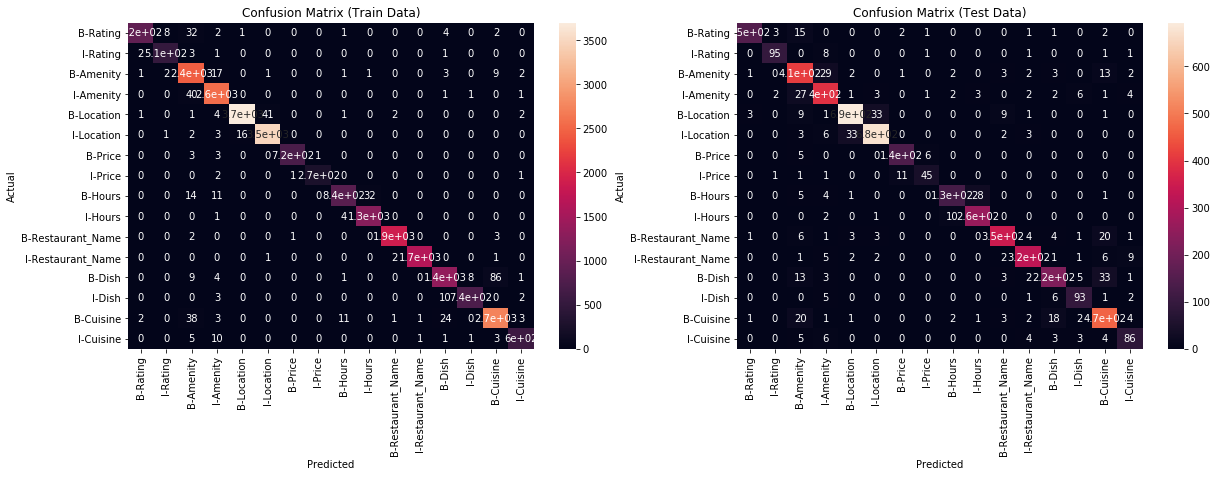

Train Data:
--------------------------------------------------------
                   precision    recall  f1-score   support

                O       1.00      1.00      1.00    248905
         B-Rating       0.97      0.86      0.91      1070
         I-Rating       0.93      0.98      0.95       527
        B-Amenity       0.92      0.96      0.94      2541
        I-Amenity       0.94      0.96      0.95      2676
       B-Location       0.98      0.97      0.97      3817
       I-Location       0.97      0.96      0.96      3658
          B-Price       0.99      0.98      0.99       730
          I-Price       0.99      0.96      0.97       283
          B-Hours       0.96      0.85      0.90       990
          I-Hours       0.96      0.99      0.97      1283
B-Restaurant_Name       1.00      0.99      0.99      1901
I-Restaurant_Name       0.99      0.99      0.99      1668
           B-Dish       0.96      0.92      0.94      1475
           I-Dish       0.98      0.97      0

In [0]:
#------------------------------------------------------------------------------------------

import matplotlib.pyplot as plt

# This function is used to display the history the train/test accuracy/loss
# of the Keras training.
#
#   history - Pass in the history returned from the model.fit(...) method.
#
def display_training_loss_and_accuracy(history):
    
    plt.figure(figsize=(20,4))
    
    # summarize history for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()    


#------------------------------------------------------------------------------------------

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
 
def display_classification_confusion_matrix(keras_model, x_train, y_train, x_test, y_test, labels, mask=None):
    
    last_axis = len(y_train.shape) - 1
    axis1 = y_train.shape[last_axis]
    y_train_axis0 = int(reduce(lambda x, y: x * y, y_train.shape) / y_train.shape[last_axis])
    y_test_axis0 = int(reduce(lambda x, y: x * y, y_test.shape) / y_train.shape[last_axis])

    pred_y_train = keras_model.predict(x_train)
    pred_y_test = keras_model.predict(x_test)
    
    if y_train.shape != pred_y_train.shape:
        print ("The y_train array does not have the same shape as the result from keras_model.predict(x_train)")
        return 
    if y_test.shape != pred_y_test.shape:
        print ("The y_train array does not have the same shape as the result from keras_model.predict(x_train)")
        return 
    
    y_train = y_train.reshape((y_train_axis0, axis1))
    y_test = y_test.reshape((y_test_axis0, axis1))
    pred_y_train = pred_y_train.reshape((y_train_axis0, axis1))
    pred_y_test = pred_y_test.reshape((y_test_axis0, axis1))
    
    plt.figure(figsize=(20,6))  

    labels = np.array(labels)
    if mask is not None:
        labels_masked = labels[mask]
    else:
        labels_masked = labels

    # Convert the target labels into the categorical index
    #
    y_train_index = y_train.argmax(axis=1)
    pred_y_train_index = pred_y_train.argmax(axis=1)
    y_test_index = y_test.argmax(axis=1)
    pred_y_test_index = pred_y_test.argmax(axis=1)
    
    # Print the first Confusion Matrix for the training data
    #
    cm = confusion_matrix(y_train_index, pred_y_train_index)
    if mask is not None:
        cm = cm[:, mask][mask, :]

    cm_df = pd.DataFrame(cm, labels_masked, labels_masked)          
    plt.subplot(1, 2, 1)
    plt.title('Confusion Matrix (Train Data)')
    sns.heatmap(cm_df, annot=True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')        
    
    # Print the second Confusion Matrix for the test data
    #    
    cm = confusion_matrix(y_test_index, pred_y_test_index)
    if mask is not None:
        cm = cm[:, mask][mask, :]
    
    cm_df = pd.DataFrame(cm, labels_masked, labels_masked)          
    plt.subplot(1, 2, 2)
    plt.title('Confusion Matrix (Test Data)')
    sns.heatmap(cm_df, annot=True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')        
    
    plt.show()

    # Finally display the classification reports
    #
    print ("Train Data:")
    print ("--------------------------------------------------------")
    print(classification_report(y_train_index, pred_y_train_index, target_names=labels))
    print ("")
    print ("Test Data:")
    print ("--------------------------------------------------------")
    print(classification_report(y_test_index, pred_y_test_index, target_names=labels))
    


#.............CODES START HERE.............#
# Exclude the O tags from the confusion matrix.
#
display_classification_confusion_matrix(model, x_train, y_train, x_test, y_test, list(entity_to_index.keys()), [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
#.............CODES END HERE.............#


## A2.12 Test Your Model 

The last section here allows you to test your model. 

Write the necessary code below to predict the recognized class for each word in the sentences in the **mytext** list. Your output must look like the following:

```
    i                             : O 
    am                            : O 
    hungry                        : O 
    and                           : O 
    would                         : O 
    like                          : O 
    to                            : O 
    get                           : O 
    some                          : O 
    spaghetti                     : B-Dish 
    from                          : O 
    an                            : O 
    italian                       : B-Cuisine 
    restaurant                    : O 
    ---
    how                           : O 
    about                         : O 
    some                          : O 
    chinese                       : B-Cuisine 
    food                          : O 
    from                          : O 
    tian                          : B-Dish 
    chai                          : I-Dish 
    from                          : O 
    across                        : B-Location 
    the                           : I-Location 
    street                        : I-Location 
    ---
```


In [0]:
sentence=""
mytext = ["i am hungry and would like to get some spaghetti from an italian restaurant",  
          "how about some chinese food from tian chai from across the street"]

# TODO:
# Process and predict your data and then print the prediction
# of word to class.
#.............CODES START HERE.............#
# Process the input into a np array of words

sentence = ''.join(mytext)
s_input = [keras.preprocessing.text.text_to_word_sequence(sentence)]
s_input = keras.preprocessing.sequence.pad_sequences(s_input, maxlen=36, dtype=object, padding='post', value="--PAD--")

print(s_input)

# Predict
y = model.predict(s_input)
best_class = np.argmax(y, axis=2)

# Print the result
for i in range(len(s_input[0])):
    if s_input[0][i] == '--PAD--':
        break
    
    for label, value in entity_to_index.items():   
        if value == best_class[0][i]:
            print ("%-30s: %s " % (s_input[0][i], label))

#.............CODES END HERE.............#



[['i' 'am' 'hungry' 'and' 'would' 'like' 'to' 'get' 'some' 'spaghetti'
  'from' 'an' 'italian' 'restauranthow' 'about' 'some' 'chinese' 'food'
  'from' 'tian' 'chai' 'from' 'across' 'the' 'street' '--PAD--' '--PAD--'
  '--PAD--' '--PAD--' '--PAD--' '--PAD--' '--PAD--' '--PAD--' '--PAD--'
  '--PAD--' '--PAD--']]
i                             : O 
am                            : O 
hungry                        : O 
and                           : O 
would                         : O 
like                          : O 
to                            : O 
get                           : O 
some                          : O 
spaghetti                     : B-Dish 
from                          : O 
an                            : O 
italian                       : B-Cuisine 
restauranthow                 : O 
about                         : O 
some                          : O 
chinese                       : B-Cuisine 
food                          : O 
from                          : O 
t

## A2.13 What Potential Applications with This? 

Now that you have trained your Keras model using the ELmo Embedding, propose what potential application you can create from this? You should avoid applications such as chatbots or tag suggestions. 

A good proposed application will be able make use of new Deep Learning models but must include the ELmo-LSTM model that you have trained above.

In your description explain the following:

1. What the potential applications are that your company can do with this particular datset.
2. How your users will be able to benefit from this solution?
3. What additional models or AI capabilities do you need to complete your solution?
4. What additional datasets that your company might have to train the additional models?

.............ANSWER STARTS HERE.............

**1. What the potential applications are that your company can do with this particular dataset?** 

  We can create a dataset 'Restaurant details in Singapore (Any city name) containing the features like restaurant names, ratings, prices, locations, cuisines, working hrs. etc., by using the model we have trained above 
We can build a ML model on this Restaurant details dataset to get more insights and develop the following applications 

  i) ***Restaurant Recommendation system with integrated location recommndation***: for the users who want to eat out
    
*   Recommending popular cuisines /popular restaurants for each cuisine / popular menu item in each restaurant in a city
*   Recommending based on the amenities, for example older and Physically challenged people prefer to go to restaurant having wheelchair access and with parking or with drop off facility. 
*  If the user using my chatbot on mobile phone or website and allows location tracking, it can recommend nearby restaurants and cuisines based on the user history preference

ii) ***Location based Recommendation System***: for the users who want to start restaurant business or trying to expand restaurant branches
* Recommending the best place to start a restaurant
* Best cuisine for a specific location (For example, more Chinese people will visit Chinatown, so keeping Chinese restaurant is the most visible and preferred choice)
    
iii) ***Consumer Sentiment Analysis*** : For the restaurant owners 
* To understand how the customers, feel about their food, service and ambience, so that it will improve their sales
* What are the negative reviews, which they need to focus and address immediately, so that it won’t impact the sales negatively
    
iv) ***Price Trend Analysis*** : For the restaurant owners 
* To find the competitive price for each item based on the market trend, how much an item is priced by their competitive brands and how customer feels about the price they have kept for their item



**2. How your users will be able to benefit from this solution?**

   We can use our work to improve overall user experience for the users who use our website/ chatbot. We cater multiple types of users. For example, I have given set of users who may be benefitted benefit from our analysis
    
***Users who are looking for restaurant suggestions for eating out***
*   They can find best rated restaurant to eat and suggestions about the menu item and availability of other amenities like parking, aircon, support payment using card etc, so they can avoid inconvenience. 
   
***Business Users/ Users who want to set up a restaurant***
*    Our application Will provide best place to set a cuisine which can generate maximum revenue, so they won't get disappointed later after investing so much in their business
   
***To the government enforcement authorities / inspectors***
    
*   Enforcement authorities normally don't get a chance to check with users to verify the quality of the food and other facilities often

*   Using our application, they can directly get to know users’ feedback, so that they can revoke the restaurant license or to take other enforcement action over the restaurant which doesn't comply to government regulations and requirements. 
   
***To the government finance/budget planning authorities***
*  To know how much an average citizen is spending on food, so they can set a budget amount to support people of lower income category. 
*  Prices usually increase/vary over time. Government subsidies need to be adjusted based on the current price, to support the needy people otherwise people won't benefitted thru the subsidies

**3. What additional models or AI capabilities do you need to complete your solution?**

 We need to build a typical ML model using SVM (As SVM works well with Categorical data and content-based recommender or collaborative filtering), we need to use one hot encoding to encode categorical variables and a build recommender system
   
**4. What additional datasets that your company might have to train the additional models?**
    
  
*   The dataset which we are getting through our application is good enough to find insights of restaurants

*   If we get details of the user including the location details (latitude/longitude), of that of the users who are going to use the recommendation system, we can get a lot more information and insights from the data, which includes matching the type of consumers (**age, gender, culture, income, Parking Needed, Needed wheel chair access**, ) with the right cuisines and restaurants. 
*   For example, a person with more disposable cash may more often go for a higher star rated restaurant, which is very usually more expensive to dine in.



.............ANSWER ENDS HERE.............